## This notebook loads the parameters that can produce Turing patterns and simulate them for a random initial condition. 


![Circute 3954](3954.png "Circute 3954")

In [1]:
%config Completer.use_jedi = False
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Latex

from tqdm import tqdm
from scipy.optimize import fsolve
from scipy.linalg import eigvals
from itertools import product 


import sys
sys.path.append("/end/home/rh2310/morpho_repo/amplitude_method")
from utils import *



sys.path.append("/end/home/rh2310/morpho_repo")
from local_utils import *

from turing.three_nodes_circuits import create_circuit_3954

> The PDEs are as follows

<h3><center>$
     \frac{\partial A}{\partial t} = b_A  +   V_A  \frac{1}{1+\left(\frac{K_{AA}}{A }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BA} }\right)^{n}} -  \mu_A A + D_A \nabla^2 A,
$</center></h3>

<h3><center>$     \frac{\partial B}{\partial t} = b_B  +   V_B  \frac{1}{1+\left(\frac{K_{AB}}{A }\right)^{n}} \frac{1}{1+\left(\frac{C}{K_{CB} }\right)^{n}} -  \mu_B B + D_B \nabla^2 B,
$</center></h3>

<h3><center>$
\frac{\partial C}{\partial t} = b_C  +   V_C  \frac{1}{1+\left(\frac{A}{K_{AC} }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BC} }\right)^{n}} \frac{1}{1+\left(\frac{K_{CC}}{C }\right)^{n}} -  \mu_C C,
$</center></h3>

![Circute 3954](3954.png "Circute 3954")

Then, we define kinetic terms as

<h3><center>$f_A(A, B, C) = b_A  +   V_A  \frac{1}{1+\left(\frac{K_{AA}}{A }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BA} }\right)^{n}} -  \mu_A A$</center></h3>
<h3><center>$f_B(A, B, C) = b_B  +   V_B  \frac{1}{1+\left(\frac{K_{AB}}{A }\right)^{n}} \frac{1}{1+\left(\frac{C}{K_{CB} }\right)^{n}} -  \mu_B B$</center></h3>
<h3><center>$f_C(A, B, C) = b_C  +   V_C  \frac{1}{1+\left(\frac{A}{K_{AC} }\right)^{n}} \frac{1}{1+\left(\frac{B}{K_{BC} }\right)^{n}} \frac{1}{1+\left(\frac{K_{CC}}{C }\right)^{n}} -  \mu_C C$</center></h3>


# Load the parameters

In [8]:
with open('turing_stationary_parameters_set_2.npy', 'rb') as f:
    turing_parameters = np.load(f)

with open('turing_stationary_k_max_set_2.npy', 'rb') as f:
    turing_k_maxs = np.load(f)

# Using a PDE solver, we can get patterns

In [9]:
import sys
from pathlib import Path
sys.path.append(f"{Path.home()}/morpho_repo/turing_codebase")
from pde_solvers.cn import *

In [10]:
import time

def to(arr):
    return arr.reshape(128, 128) 

def plot(res, LXLY, index, i, save=True):

    if save:
        plot_n_im([to(res[-1, 0, :]), to(res[-1, 1, :]), to(res[-1, 2, :])], 
          ["A", "B", "C"],          
          figsize=(12, 3)); plt.tight_layout()
        plt.savefig(f"./outputs_second_search/solution_{LXLY}_{index}_{i}.png", bbox_inches="tight")
        plt.close()
    
    
def  init_values(model, A_star, B_star, C_star):
    A = np.random.normal(scale=A_star*.1, size=(model.Ix*model.Jy))
    A += A_star
    #
    B = np.random.normal(scale=B_star*.1, size=(model.Ix*model.Jy))
    B += B_star
    #
    C = np.random.normal(scale=C_star*.1, size=(model.Ix*model.Jy))
    C += C_star
    return (A, B, C)
    
    

def single_proccess(args):    
    index, params, k_maxs = args
    D_A_val, D_B_val = 0.01, 1.0
    model_128_10 = RD_2D_1st_Order(Ds=[D_A_val, D_B_val, 0], N=5000, T=100, Lx=10, Ly=10, 
                                   Ix=128, Jy=128,
                                   boundary_condition=Neumann_Boundary_2D)
    
    for i  in range(len(params)):
        (n_val, 
         b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
         b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
         b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params[i, :]
    
    
        kinetics = create_circuit_3954(n_val, 
                                       b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                                       b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                                       b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)   
        def k(args):
            A,B,C = args
            return kinetics(A,B,C)
            
    
        def find_roots(verbose=False):    
            func = k
            #
            roots_res = []
            for init_vals in product([.1,-.1], repeat=3):        
                roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
                (a_1, b_1, c_1) = func(roots)
                if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
                    roots_res.append(roots)
                    return roots_res
            for init_vals in product([1,-1], repeat=3):        
                roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
                (a_1, b_1, c_1) = func(roots)
                if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
                    roots_res.append(roots)
                    return roots_res

            for init_vals in product([10,-10], repeat=3):        
                roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
                (a_1, b_1, c_1) = func(roots)
                if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
                    roots_res.append(roots)
                    return roots_res

            for init_vals in product([100,-100], repeat=3):        
                roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
                (a_1, b_1, c_1) = func(roots)
                if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
                    roots_res.append(roots)
                    return roots_res

            if len(roots_res) == 0:
                if verbose:
                    print(msg)
                    print("roots:", roots)
                    print("values", a_1, b_1, c_1)
                return roots_res 
            else:
                roots_res2 = [roots_res[0]]
                for item in roots_res[1:]:
                    if np.any(item < 0):
                        continue
                    if not np.any([np.isclose(item2, item) for item2 in roots_res2]):
                        roots_res2.append(item)
                return roots_res2 
    
        roots = find_roots()
        if len(roots) == 0:
            continue
            
        A_star, B_star, C_star = roots[0]

        start_time = time.time()
        (A, B, C) = init_values(model_128_10, A_star, B_star, C_star)        
        res_128_10 = model_128_10.integrate([A,B,C], kinetics, 500)
        plot(res_128_10, 10, index, i)
        with open(f"./outputs_second_search/solution_10_{index}_{i}.npy", "wb") as f:
            np.save(f, (k_maxs[i], params[i, :], res_128_10))
        
    
    return index#(index, res_128_50, res_128_10, res_128_1)
    

    

In [5]:
len(turing_parameters)

86956

In [16]:
[(i*part_len,(i+1)*part_len)  for i in range(num_process)]

[(0, 200),
 (200, 400),
 (400, 600),
 (600, 800),
 (800, 1000),
 (1000, 1200),
 (1200, 1400),
 (1400, 1600),
 (1600, 1800),
 (1800, 2000),
 (2000, 2200),
 (2200, 2400),
 (2400, 2600),
 (2600, 2800)]

In [14]:
from multiprocessing import Pool
num_process = 14
part_len = 200#2295816#2087105
previous_runs = 0
args_list = [(i + previous_runs, 
              turing_parameters[i*part_len:(i+1)*part_len, :],
              turing_k_maxs[i*part_len:(i+1)*part_len])  for i in range(num_process)]

In [15]:
with Pool(num_process) as p:
    res = p.map(single_proccess, args_list)

/usr/local/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/usr/local/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_ds

In [106]:
D_A_val, D_B_val = 0.01, 1.0
model_128_10 = RD_2D_1st_Order(Ds=[D_A_val, D_B_val, 0], N=10*10000, T=10*200, Lx=10, Ly=10, 
                               Ix=128, Jy=128,
                               boundary_condition=Neumann_Boundary_2D)

/usr/local/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


In [12]:
with open(f"./outputs_second_search/solution_10_0_18.npy", "rb") as f:
    params_temp, res_temp =   np.load(f , allow_pickle=True)

In [107]:
def single_sim(params):    
    
    
    
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params


    kinetics = create_circuit_3954(n_val, 
                                   b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                                   b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                                   b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)   
    def k(args):
        A,B,C = args
        return kinetics(A,B,C)


    def find_roots(verbose=False):    
        func = k
        #
        roots_res = []
        for init_vals in product([.1,-.1], repeat=3):        
            roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
            (a_1, b_1, c_1) = func(roots)
            if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
                roots_res.append(roots)
                return roots_res
        for init_vals in product([1,-1], repeat=3):        
            roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
            (a_1, b_1, c_1) = func(roots)
            if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
                roots_res.append(roots)
                return roots_res

        for init_vals in product([10,-10], repeat=3):        
            roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
            (a_1, b_1, c_1) = func(roots)
            if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
                roots_res.append(roots)
                return roots_res

        for init_vals in product([100,-100], repeat=3):        
            roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
            (a_1, b_1, c_1) = func(roots)
            if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
                roots_res.append(roots)
                return roots_res

        if len(roots_res) == 0:
            if verbose:
                print(msg)
                print("roots:", roots)
                print("values", a_1, b_1, c_1)
            return roots_res 
        else:
            roots_res2 = [roots_res[0]]
            for item in roots_res[1:]:
                if np.any(item < 0):
                    continue
                if not np.any([np.isclose(item2, item) for item2 in roots_res2]):
                    roots_res2.append(item)
            return roots_res2 

    roots = find_roots()
    if len(roots) == 0:
        return None

    A_star, B_star, C_star = roots[0]

    #start_time = time.time()
    #(A, B, C) = init_values(model_128_10, A_star, B_star, C_star)
    xs = np.linspace(0, 1, model_128_10.Ix)*model_128_10.Lx
    ys = np.linspace(0, 1, model_128_10.Jy)*model_128_10.Ly

    X, Y = np.meshgrid(xs, ys)
    k_c = 2*np.pi/0.385
    
    
    #(A, B, C) = init_values(model_128_10, A_star, B_star, C_star) 
    
    A =  20.0*np.sin( k_c*X ).flatten()
    A += A_star    
    B =  20.0*np.sin( k_c*X + np.pi).flatten()
    B += B_star
    C =  20.0*np.sin( k_c*X ).flatten()
    C += C_star
    
    res_128_10 = model_128_10.integrate([A,B,C], kinetics, 50)
    #plot(res_128_10, 10, index, i)
    #with open(f"./outputs_second_search/solution_10_{index}_{i}.npy", "wb") as f:
    #    np.save(f, (params[i, :], res_128_10))
        
    
    return res_128_10

In [108]:
res_temp = single_sim(params_temp)

MovieWriter imagemagick unavailable; using Pillow instead.


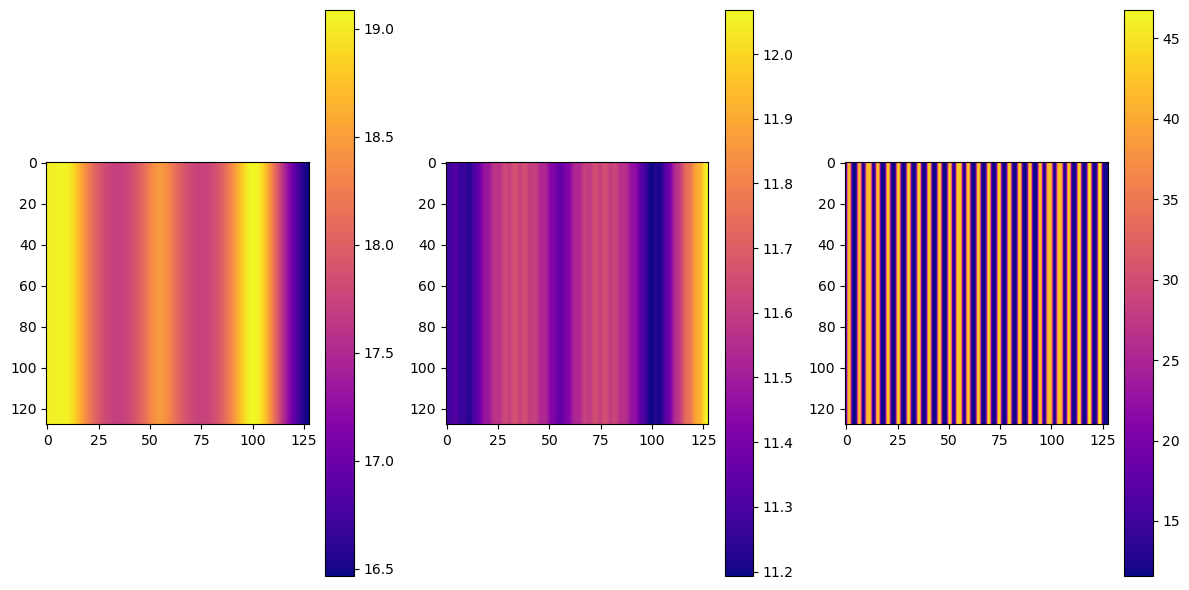

In [109]:
from matplotlib.animation import FuncAnimation
import matplotlib as mpl
from matplotlib.animation import PillowWriter

def to(arr):
    return arr.reshape((128, 128))

fig = plt.figure(figsize=(12,6))

index = 0
first_or_last = -1

def plt_one(arr, index, i):
    vmin = np.min(arr[first_or_last, index , :])
    vmax = np.max(arr[first_or_last, index , :])
    levels=np.linspace(vmin, vmax, 10, endpoint = True)


    im = plt.imshow(to(arr[i, index,:]), 
                    cmap='plasma',
                    vmin=vmin,
                    vmax=vmax,
                    interpolation='gaussian')

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='plasma'))
    return im

plt.subplot(131)
im1 = plt_one(res_temp, 0, 0)
plt.subplot(132)
im2 = plt_one(res_temp, 1, 0)
plt.subplot(133)
im3 = plt_one(res_temp, 2, 0)
plt.tight_layout()


#im = im=plt.imshow(to(res_temp[0, index,:]))#  ,interpolation='none')
def init():
    im1.set_data(to(res_temp[0, 0,:]))    
    im2.set_data(to(res_temp[0, 1,:]))
    im3.set_data(to(res_temp[0, 2,:]))
    return [im1, im2, im3]
    
def animate(i):    
    
    fig.clear()
#     im = plt.imshow(to(res_temp[i, index, :]), 
#                     cmap='plasma',
#                     vmin=vmin,
#                     vmax=vmax,
#                     interpolation='gaussian')#, alpha=0.8)#  ,interpolation='none'
    #cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='plasma'))
    plt.subplot(131)
    im1 = plt_one(res_temp, 0, i)
    plt.subplot(132)
    im2 = plt_one(res_temp, 1, i)
    plt.subplot(133)
    im3 = plt_one(res_temp, 2 , i)
    plt.tight_layout()
    return [im1, im2, im3]

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=res_temp.shape[0], interval=100, blit=True)


anim.save('solution_10_0_18_init_4.gif', writer='imagemagick')

In [38]:
res_temp.shape

(200, 3, 16384)

In [100]:
xs = np.linspace(0, 1, model_128_10.Ix)*model_128_10.Lx
ys = np.linspace(0, 1, model_128_10.Jy)*model_128_10.Ly

X, Y = np.meshgrid(xs, ys)
Z= np.sin( 2*np.pi*X/0.385 )

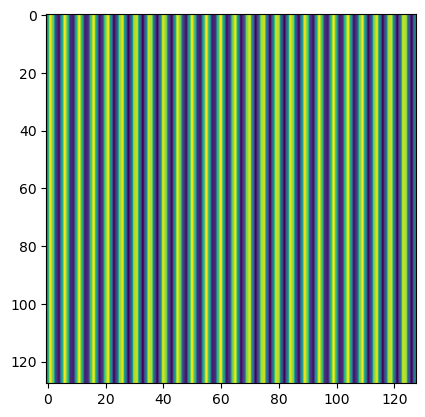

In [101]:
plt.imshow(Z)

In [79]:
model_128_10.Ix

128

In [24]:
D_A_val, D_B_val = 0.01, 1.0
model_128_10_2 = RD_2D_1st_Order(Ds=[D_A_val, D_B_val, 0], N=4*2500, T=100, Lx=10, Ly=10, 
                               Ix=128, Jy=128,
                               boundary_condition=Neumann_Boundary_2D)

/usr/local/anaconda3/lib/python3.9/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:347: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)


In [25]:
def single_sim2(params):    
    
    
    
    (n_val, 
     b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
     b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
     b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val) = params


    kinetics = create_circuit_3954(n_val, 
                                   b_A_val, mu_A_val, V_A_val, K_AA_val, K_AB_val, K_AC_val,
                                   b_B_val, mu_B_val, V_B_val, K_BA_val, K_BC_val,
                                   b_C_val, mu_C_val, V_C_val, K_CB_val, K_CC_val)   
    def k(args):
        A,B,C = args
        return kinetics(A,B,C)


    def find_roots(verbose=False):    
        func = k
        #
        roots_res = []
        for init_vals in product([.1,-.1], repeat=3):        
            roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
            (a_1, b_1, c_1) = func(roots)
            if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
                roots_res.append(roots)
                return roots_res
        for init_vals in product([1,-1], repeat=3):        
            roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
            (a_1, b_1, c_1) = func(roots)
            if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
                roots_res.append(roots)
                return roots_res

        for init_vals in product([10,-10], repeat=3):        
            roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
            (a_1, b_1, c_1) = func(roots)
            if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
                roots_res.append(roots)
                return roots_res

        for init_vals in product([100,-100], repeat=3):        
            roots, d, ier, msg = fsolve(func, init_vals, xtol=1e-7, maxfev=10000,  full_output=1)
            (a_1, b_1, c_1) = func(roots)
            if ier == 1 and a_1 < 1e-7 and b_1 < 1e-7 and c_1 < 1e-7:
                roots_res.append(roots)
                return roots_res

        if len(roots_res) == 0:
            if verbose:
                print(msg)
                print("roots:", roots)
                print("values", a_1, b_1, c_1)
            return roots_res 
        else:
            roots_res2 = [roots_res[0]]
            for item in roots_res[1:]:
                if np.any(item < 0):
                    continue
                if not np.any([np.isclose(item2, item) for item2 in roots_res2]):
                    roots_res2.append(item)
            return roots_res2 

    roots = find_roots()
    if len(roots) == 0:
        return None

    A_star, B_star, C_star = roots[0]

    
    (A, B, C) = init_values(model_128_10_2, A_star, B_star, C_star) 
    
    
    res_128_10 = model_128_10_2.integrate([A,B,C], kinetics, 50)
    #plot(res_128_10, 10, index, i)
    #with open(f"./outputs_second_search/solution_10_{index}_{i}.npy", "wb") as f:
    #    np.save(f, (params[i, :], res_128_10))
        
    
    return res_128_10

In [26]:
np.set_printoptions(precision=3, suppress=True)

In [27]:
args_list[7][1][4]

array([  4.   ,   0.001,   0.1  ,  10.   ,   0.1  ,   0.5  ,  20.   ,
         0.1  ,   1.   ,  50.   ,   0.5  ,  10.   ,   0.5  ,   0.1  ,
        25.   , 100.   , 100.   ])

In [ ]:
0.001 0.1 10.0 0.1 0.1 0.5
0.001 0.1 20.0 20.0 0.5
20.0 100.0 100.0 5.0 1.0

In [28]:
#res_test = single_sim2(turing_parameters[100])
res_test = single_sim2(args_list[7][1][4])

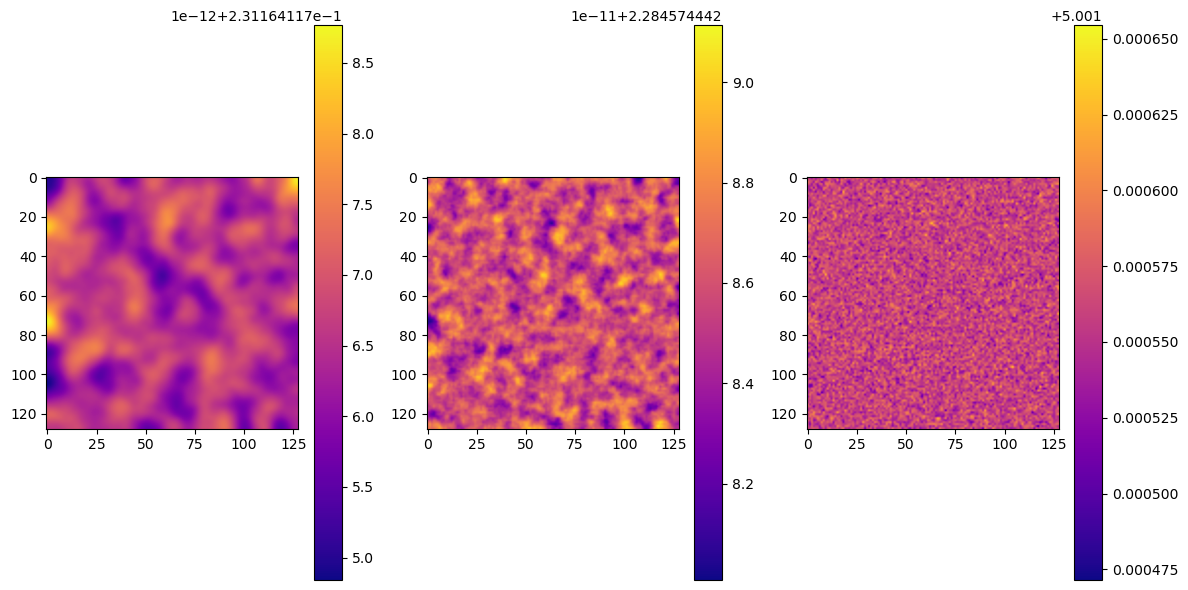

In [30]:
import matplotlib as mpl

fig = plt.figure(figsize=(12,6))

index = 0
first_or_last = -1

def plt_one(arr, index, i):
    vmin = np.min(arr[first_or_last, index , :])
    vmax = np.max(arr[first_or_last, index , :])
    levels=np.linspace(vmin, vmax, 10, endpoint = True)


    im = plt.imshow(to(arr[i, index,:]), 
                    cmap='plasma',
                    vmin=vmin,
                    vmax=vmax,
                    interpolation='gaussian')

    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    cb = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='plasma'))
    #im = plt.imshow(to(arr[i, index,:]))
    return im

plt.subplot(131)
im1 = plt_one(res_test, 0, -1)
plt.subplot(132)
im2 = plt_one(res_test, 1, -1)
plt.subplot(133)
im3 = plt_one(res_test, 2, -1)
plt.tight_layout()